## Problem statement

Start with the initial-value problem for the scalar differential equation $f: x'(t) = -x(t)$, $x(0) = x_0$.

The analytic solution is

$$
x(t) = x_0 e^{-t}.
$$

Consider the hybrid autmaton with just one mode associated to $f$ and a self-loop, with time-triggered transitions that occur at sampling times $T_s$. The reset map is taken to be $M: x \mapsto 2x$.

We'll begin by considering deterministic switchings, i.e. transitions occur at multiples of the sampling time: $[T_s, 2T_s, \ldots, k_{max}T_s]$ for some $k_{max} \in \mathbb{N}$. Note that $k_{max}$ is what we call the maximum number of jumps or `max_jumps.`

In the scenario of non-deterministic switchings, we introduce $[\zeta-, \zeta_+] \subset \mathbb{R}$ (an interval that contains the origin) such that transitions may occur at any time point within the intervals $[T_s + \zeta_-, T_s + \zeta_+]$, $[2T_s + \zeta_-, 2T_s + \zeta_+]$, etc. until $[k_{max}T_s + \zeta_-, k_{max}T_s + \zeta_+]$

## Analytic solution

The analytic solution for a given initial state $x_0 \in \mathbb{R}$ is the union $S_1 \cup S_2 \cup \cdots \cup S_{k_{max}}$, where the $S_k$ are given by:

$$
S_1: x(t) = x_0e^{-t},\qquad t \in [0, T_s) \\
S_2: x(t) = \left( 2x_0e^{-T_s} \right) e^{-(t-T_s)},\qquad t \in [T_s, 2T_s) \\
S_3: x(t) = \left( 4x_0e^{-2T_s} \right) e^{-(t-2T_s)},\qquad t \in [2T_s, 3T_s) \\
\vdots \\
S_k: x(t) = \left( 2^{(k-1)}x_0e^{-(k-1)T_s} \right) e^{-(t-(k-1)T_s)},\qquad t \in [(k-1)T_s, kT_s) \\
\vdots \\
S_{k_{max}-1}: x(t) = \left( 2^{(k_{max}-2)}x_0e^{-(k_{max}-2)T_s} \right)e^{-(t-(k_{max}-2)T_s)},\qquad t \in [(k_{max}-2)T_s, (k_{max}-1)T_s) \\
S_{k_{max}}: x(t) = \left( 2^{(k_{max}-1)}x_0e^{-(k_{max}-1)T_s} \right)e^{-(t-(k_{max}-1)T_s)},\qquad t \in [(k_{max}-1)T_s, k_{max}T_s) \\
$$

Let's visualize this solution given the data: $x_0 = 10$, $T_s = 1.0$ and $k_{max} = 4$.

In [1]:
using Plots

In [2]:
S(t, x0, Ts, k) = (2^(k-1) * x0 * exp(-(k-1)*Ts)) * exp(-(t-(k-1)*Ts));

function step(t, x0, Ts, k)
    cond = ((k-1) * Ts <= t) && (t <= k * Ts)
    return cond ? S(t, x0, Ts, k) : 0.0
end

step (generic function with 1 method)

Check that the value at $S_2(t = T_s)$ corresponds to twice the value of $S_1(t = T_2)$:

In [16]:
step(Ts, x0, Ts, 1) * 2.0

7.357588823428847

In [17]:
step(Ts, x0, Ts, 2)

7.357588823428847

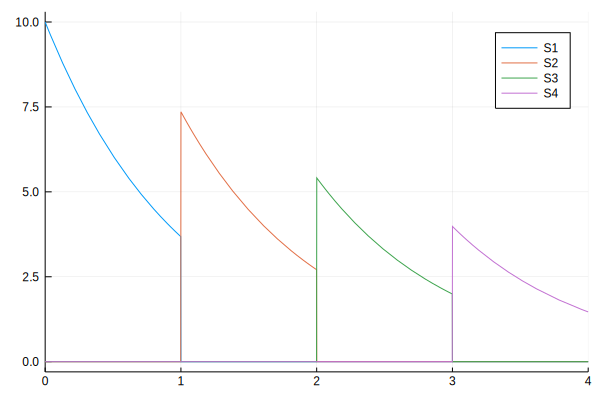

In [131]:
x0 = 10.0
Ts = 1.0
kmax = 4

fig = plot()
for k in 1:kmax
    plot!(fig, t -> step(t, x0, Ts, k), xlims=(0, kmax), lab="S$k")
end
fig

## Reachability result

In [4]:
using Revise, ReachabilityAnalysis

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260


Define the hybrid automaton with clocked linear dynamics and one mode:

In [18]:
prob = @ivp(HACLD1(@system(x' = -x), x -> 2x, 1.0), x(0) ∈ 10.0 .. 10.0);

The flowpipe with step size $\delta = 0.1$ covers the trajetories.

In [19]:
sol = solve(prob, T=4.0, alg=INT(δ=0.1));

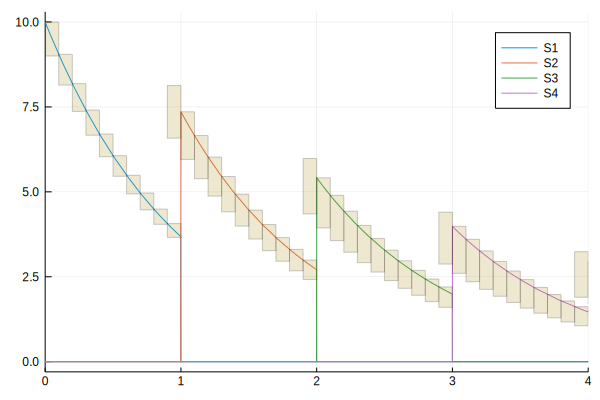

In [20]:
plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2)

Trying with smaller step we get more accurate solutions.

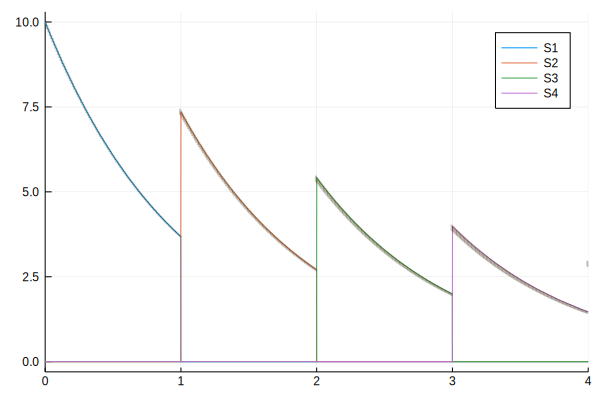

In [90]:
sol = solve(prob, T=4.0, alg=INT(δ=0.01));
plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2)

## Understanding the behavior at the transition

In [91]:
# equivalent problem but we knowing that x is an interval
prob = @ivp(HACLD1(@system(x' = -x), x -> Interval(2.0 * x.dat), 1.0), x(0) ∈ 10.0 .. 10.0);

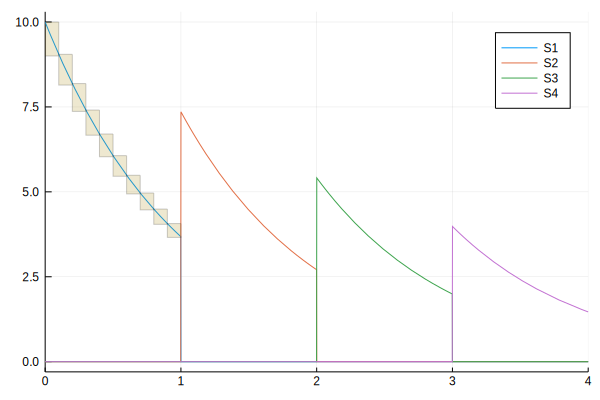

In [92]:
sol = solve(prob, T=4.0, alg=INT(δ=0.1));
plot!(deepcopy(fig), sol[1], vars=(0, 1), alpha=.2)

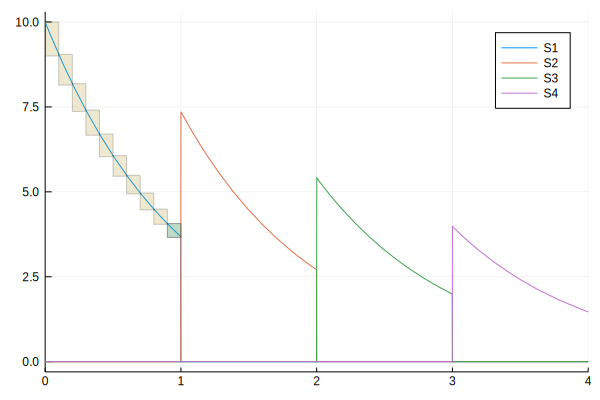

In [93]:
plot!(sol[1][end], vars=(0, 1), alpha=.2)

In [94]:
# applying the reset map
Y = prob.s.rmap(set(sol[1][end]))
R = ReachSet(Y, tspan(sol[1], length(sol[1])))

ReachSet{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}([7.31825, 8.1314]), [0.899999, 1.00001])

Now we have the reset map, we want to apply the discretization.

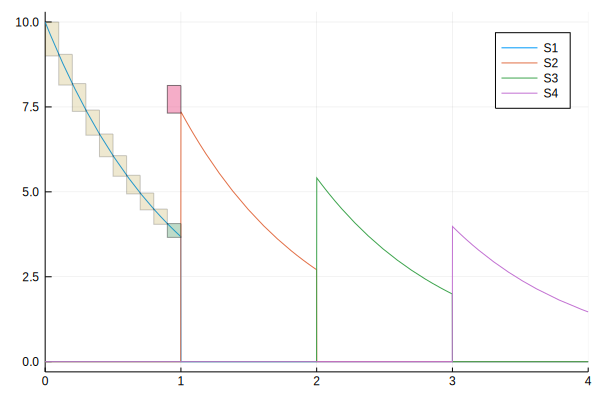

In [95]:
plot!(R, vars=(0, 1))

---

## Deterministic case with step size which is not a multiple of the sampling time

In [75]:
prob = @ivp(HACLD1(@system(x' = -x), x -> 2x, 1.0), x(0) ∈ 10.0 .. 10.0);

In [83]:
sol = solve(prob, T=5.0, alg=INT(δ=0.09));

NLOW = 12
NHIGH = 12


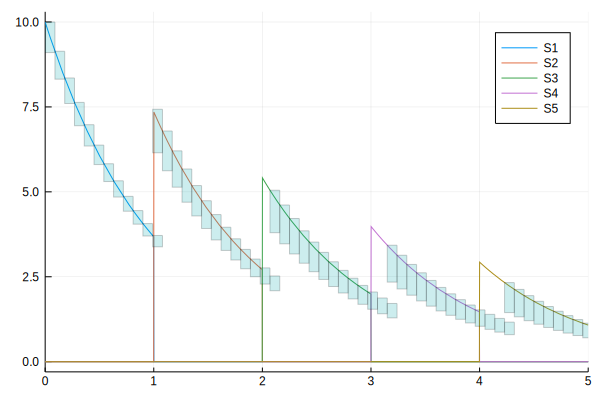

In [84]:
plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2)

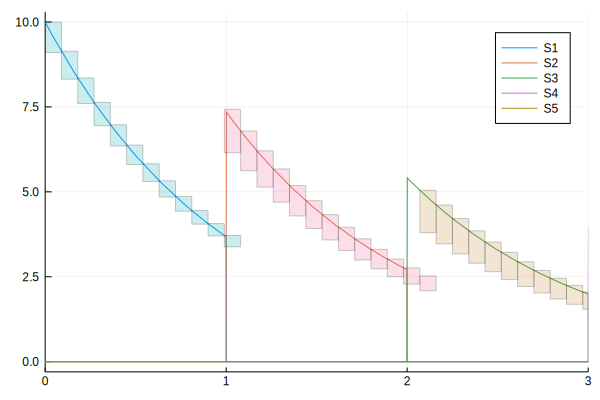

In [85]:
fig3 = deepcopy(fig)
plot!(fig3, sol[1], vars=(0, 1), alpha=.2)
plot!(fig3, sol[2], vars=(0, 1), alpha=.2)
plot!(fig3, sol[3], vars=(0, 1), alpha=.2, xlims=(0.0, 3.0))

In [87]:
tspan(sol[1], 12)

[0.989999, 1.08001]

Let's zoom in the first transition:

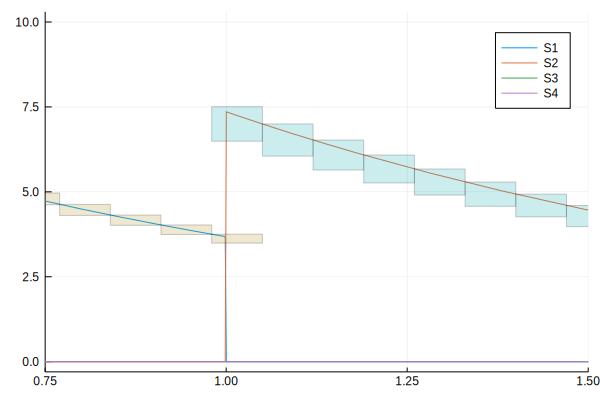

In [130]:
fig2 = plot!(deepcopy(fig), sol[1], vars=(0, 1), alpha=.2, xlims=(0.75, 1.5))
plot!(fig2, sol[2], vars=(0, 1), alpha=.2)

### Adjust t0 and do not add 1 to NLOW and NHIGH

In [97]:
prob = @ivp(HACLD1(@system(x' = -x), x -> 2x, 1.0), x(0) ∈ 10.0 .. 10.0);

In [98]:
sol = solve(prob, T=5.0, alg=INT(δ=0.09));

NLOW = 12
NHIGH = 12


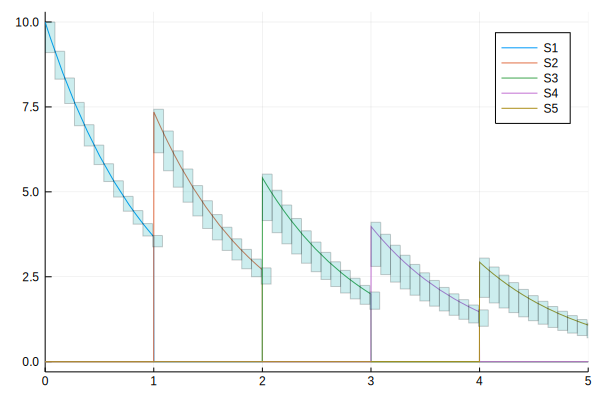

In [99]:
plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2)

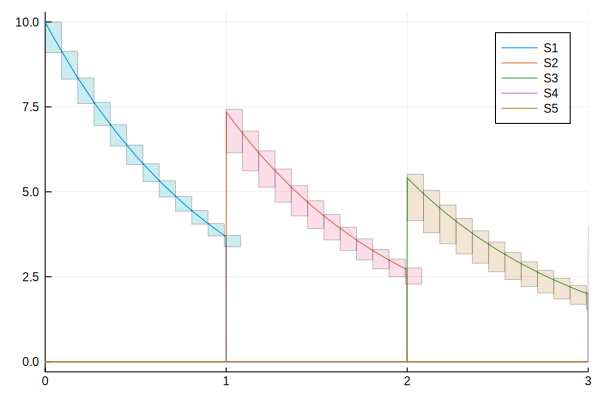

In [100]:
fig3 = deepcopy(fig)
plot!(fig3, sol[1], vars=(0, 1), alpha=.2)
plot!(fig3, sol[2], vars=(0, 1), alpha=.2)
plot!(fig3, sol[3], vars=(0, 1), alpha=.2, xlims=(0.0, 3.0))

#### Longer time span

In [117]:
sol = solve(prob, T=15.0, alg=INT(δ=0.099));

NLOW = 11
NHIGH = 11


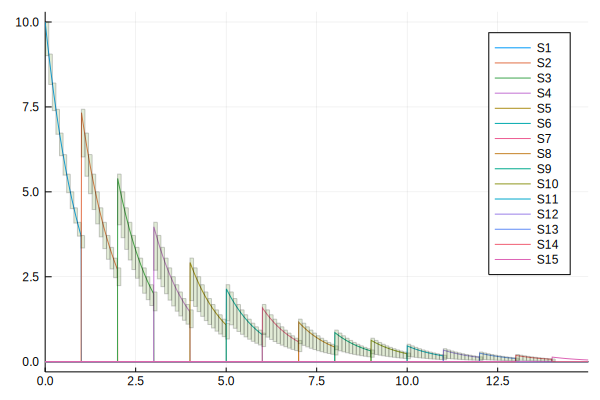

In [118]:
plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2)

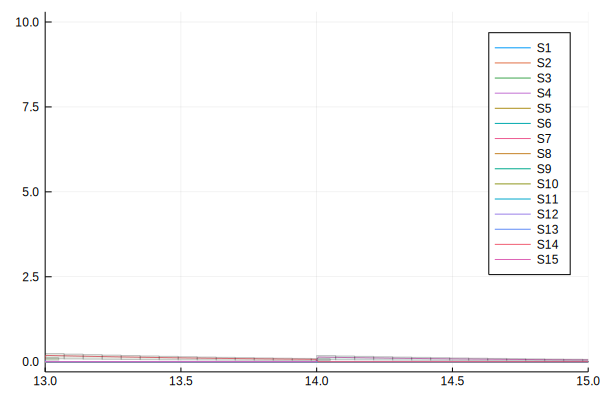

In [112]:
fig3 = deepcopy(fig)
plot!(fig3, sol[13], vars=(0, 1), alpha=.2)
plot!(fig3, sol[14], vars=(0, 1), alpha=.2)
plot!(fig3, sol[15], vars=(0, 1), alpha=.2, xlims=(13.0, 15.0))

In [119]:
sol = solve(prob, T=15.0, alg=INT(δ=0.1));

NLOW = 10
NHIGH = 10


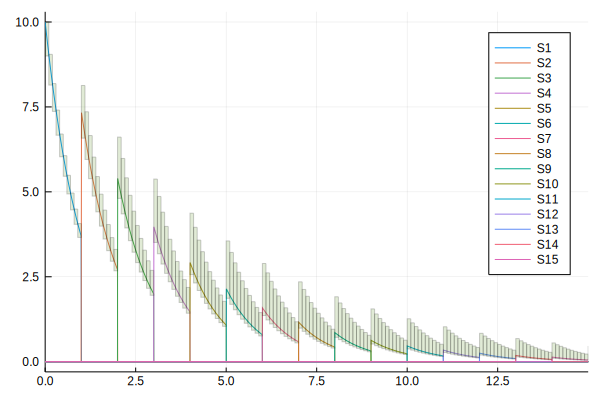

In [121]:
plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2, lab="")

## Non-deterministic switching

About the analytic solutions, even if we consider only the "limiting" trajectories, i.e. those which present transitions at either $T_s + \zeta^-$ or $T_s + \zeta^+$, there is an exponential number of such trajectories because there are $2^k$ choices for $k$ transitions.

In [124]:
prob = @ivp(HACLD1(@system(x' = -x), x -> 2x, 1.0, 1e-1), x(0) ∈ 10.0 .. 10.0);

In [125]:
prob.s.ζ

[-0.100001, 0.100001]

In [127]:
sol = solve(prob, T=4.0, alg=INT(δ=0.05));

NLOW = 18
NHIGH = 22


In `master` we get the following plot because we were storing only up to `NLOW`. But in reality we should store up to `NHIGH`, since the transitin could take place until $T_s + \zeta^+$.

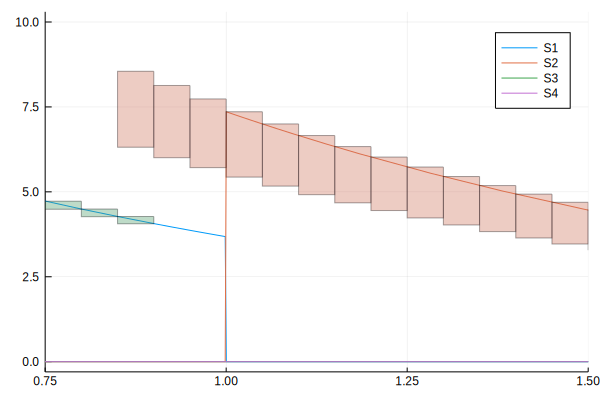

In [136]:
fig3 = plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2, xlims=(0.75, 1.5))
plot!(fig3, sol[1], vars=(0, 1), alpha=.2)
plot!(fig3, sol[2], vars=(0, 1), alpha=.2)

Note that there are trajectories which *have not taken the transition* until $T_s + \zeta = 1.1$.

The following set is obtained after making the change proposed in PR.

In [12]:
sol = solve(prob, T=4.0, alg=INT(δ=0.05));

NLOW = 18
NHIGH = 22


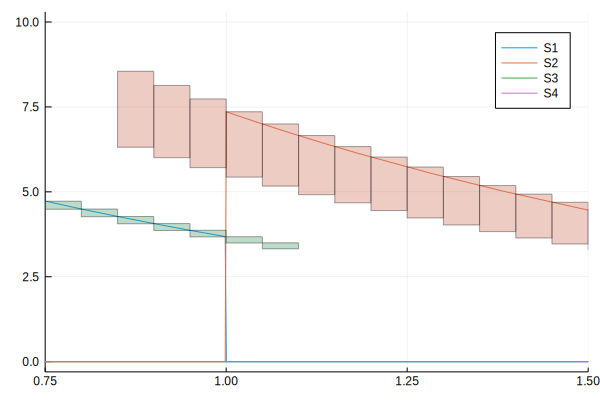

In [13]:
fig3 = plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2, xlims=(0.75, 1.5))
plot!(fig3, sol[1], vars=(0, 1), alpha=.2)
plot!(fig3, sol[2], vars=(0, 1), alpha=.2)

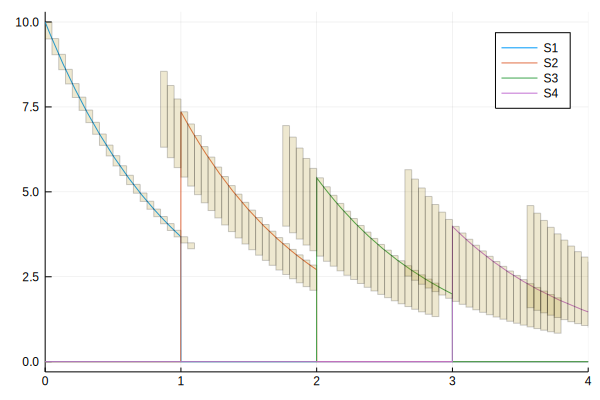

In [14]:
plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2)

----

### Try after the fixes

In [154]:
prob = @ivp(HACLD1(@system(x' = -x), x -> 2x, 1.0, 1e-1), x(0) ∈ 10.0 .. 10.0);

In [157]:
sol = solve(prob, T=4.0, alg=INT(δ=0.03));

NLOW = 31
NHIGH = 37


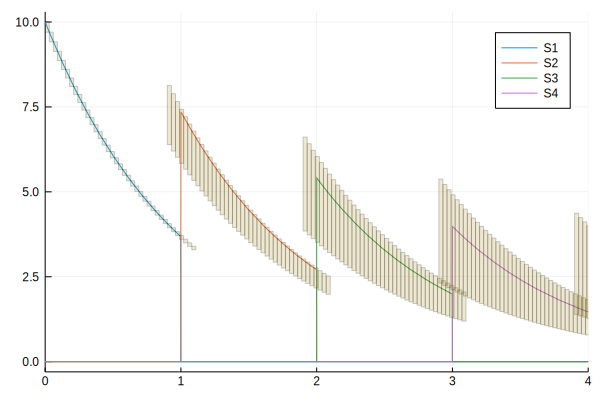

In [158]:
plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2)

In [153]:
ceil(1.1 / 0.05)

22.0

In [151]:
ceil(Int, 0.1 / 0.05)

2

$T_s + \eta^-$

$2T_s + \eta^-$

$3T_s + \eta^-$

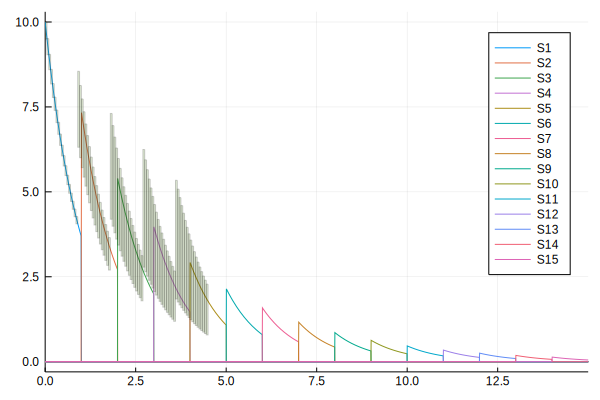

In [130]:
fig3 = plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2, xlims=(0.75, 1.5))
plot!(fig3, sol[1], vars=(0, 1), alpha=.2)
plot!(fig3, sol[2], vars=(0, 1), alpha=.2)

#plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2)

In [ ]:
fig3 = plot!(deepcopy(fig), sol, vars=(0, 1), alpha=.2, xlims=(0.75, 1.5))
plot!(fig3, sol[1], vars=(0, 1), alpha=.2)
plot!(fig3, sol[2], vars=(0, 1), alpha=.2)